# Euler waveguide bend

Efficiently routing light in a densely packed photonic chip has been a central topic in the photonic industry. This inevitably requires the use of waveguide bends of various angles and radii. Electromagnetic waves can travel in straight waveguides for a long distance with very little loss. However, when it enters a waveguide bend, significant reflection and leakage could occur. 

The most common waveguide bends are circular bends. A silicon waveguide bend typically has a loss in the order of 0.01 dB. This loss is sufficiently small for many applications. However, in cases where a large number of bends are used, the total loss due to the bends can be quite large. Therefore, new methods to reduce bending loss is needed. Recently, [T. Fujisawa et al.](https://opg.optica.org/oe/fulltext.cfm?uri=oe-25-8-9150&id=362937) demonstrated that a waveguide bend following the clothoid curve, also known as the Euler bend, yields a much lower loss compared to a circular bend due to its smooth curvature transition. In this example notebook, we model a 90 degree Euler waveguide bend and compare its loss to a conventional circular bend. The loss of the Euler waveguide bend is found to be several times smaller compared to the circular bend of the same effective radius at the telecom wavelength.

<img src="img/euler_bend_schematic.png" width="500" alt="Schematic of the waveguide bends">

For more integrated photonic examples such as the [8-Channel mode and polarization de-multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/8ChannelDemultiplexer/), the [broadband bi-level taper polarization rotator-splitter](https://www.flexcompute.com/tidy3d/examples/notebooks/BilevelPSR/), and the [broadband directional coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/BroadbandDirectionalCoupler/), please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.optimize import fsolve
import gdstk

import tidy3d as td
import tidy3d.web as web


## Clothoid Bend vs. Circular Bend

The expression for a clothoid curve (Euler curve) whose starting point is at the origin is given by 

$$
x = A \int_{0}^{L/A} cos(\frac{\theta^2}{2})d\theta,
$$
$$
y = A \int_{0}^{L/A} sin(\frac{\theta^2}{2})d\theta,
$$
and 
$$
RL=A^2,
$$
where $A$ is the clothoid parameter, $L$ is the curve length from $(0,0)$ to $(x,y)$, and $1/R$ is the curvature at $(x,y)$. At the end point of the clothoid curve, the curve length is $L_{max}$ and the curvature is $1/R_{min}$. Unlike a circular curve, the curvature of a clothoid curve varies linearly from 0 to $1/R_{min}$. A 90 degree Euler waveguide bend is constructed by connecting two pieces of clothoid curves with a circular curve. One clothoid curve starts at $(0,0)$ and the other starts at $(R_{eff},R_{eff})$, where $R_{eff}$ is the effective waveguide bending radius. To ensure a smooth transition of curvature, we choose a $L_{max}$ such that the derivative is continuous at the connecting points.

In this example notebook, we model waveguide bends with a 4 $\mu m$ effective bending radius. First, we plot the shapes of the two types of bends to get a sense of how the Euler bend and the circular bend differ. More specifically, we try the case with $A=2.4$.

In [2]:
R_eff = 4  # effective radius of the bend
A = 2.4  # clothoid parameter


An important step in constructing the Euler bend is to determine $L_{max}$. Here we do it numerically by first setting $L_{max}=0$. $L_{max}$ is then slowly increased at some small step. At each increment, we check if the tangent curve is perpendicular to that of the circular curve. Once this condition is met, we obtain the correct value of $L_{max}$ as well as the coordinates of the clothoid.

In [3]:
L_max = 0  # starting point of L_max
precision = 0.05  # increasement of L_max at each iteration
tolerance = 0.01  # difference tolerance of the derivatives

# determine L_max
while True:
    L_max = L_max + precision  # update L_max
    Ls = np.linspace(0, L_max, 50)  # L at (x1,y1)
    x1 = np.zeros(len(Ls))  # x coordinate of the clothoid curve
    y1 = np.zeros(len(Ls))  # y coordinate of the clothoid curve

    # compute x1 and y1 using the above integral equations
    for i, L in enumerate(Ls):
        y1[i], err = integrate.quad(lambda theta: A * np.sin(theta**2 / 2), 0, L / A)
        x1[i], err = integrate.quad(lambda theta: A * np.cos(theta**2 / 2), 0, L / A)

    # compute the derivative at L_max
    k = -(x1[-1] - x1[-2]) / (y1[-1] - y1[-2])
    xp = x1[-1]
    yp = y1[-1]
    # check if the derivative is continuous at L_max
    R = np.sqrt(
        ((R_eff + k * xp - yp) / (k + 1) - xp) ** 2
        + (-(R_eff + k * xp - yp) / (k + 1) + R_eff - yp) ** 2
    )
    if np.abs(R - A**2 / L_max) < tolerance:
        break

# after L_max is determined, R_min is also determined
R_min = A**2 / L_max


After determining the first piece of the clothoid curve, the second piece can be obtained simply by mirroring it with respect to $y=-x+R_{eff}$.

In [4]:
# getting the coordinates of the second clothoid curve by mirroring the first curve with respect to y=-x+R_eff
x3 = np.flipud(R_eff - y1)
y3 = np.flipud(R_eff - x1)


The last step is to determine the circular curve connecting the clothoid curves. This can be done simply by enforcing a circle $(x-a)^2+(y-b)^2=R_{min}^2$ to pass the endpoints of the clothoid curves. Here, we use the `fsolve` function from `scipy.optimize` to solve for $a$ and $b$.

In [5]:
# solve for the parameters of the circular curve
def circle(var):
    a = var[0]
    b = var[1]
    Func = np.empty((2))
    Func[0] = (xp - a) ** 2 + (yp - b) ** 2 - R_min**2
    Func[1] = (R_eff - yp - a) ** 2 + (R_eff - xp - b) ** 2 - R_min**2
    return Func


a, b = fsolve(circle, (0, R_eff))

# calculate the coordinates of the circular curve
x2 = np.linspace(xp + 0.01, R_eff - yp - 0.01, 50)
y2 = -np.sqrt(R_min**2 - (x2 - a) ** 2) + b


Now we have obtained the coordinates of the whole Euler bend, we can plot it with a conventional circular bend to see the difference. Compared to the circular bend, we can see the Euler bend has a smaller curvature at $(0,0)$ and $(R_{eff},R_{eff})$. This allows a slower transition to and from the straight waveguides, which leads to smaller reflection and scattering loss.

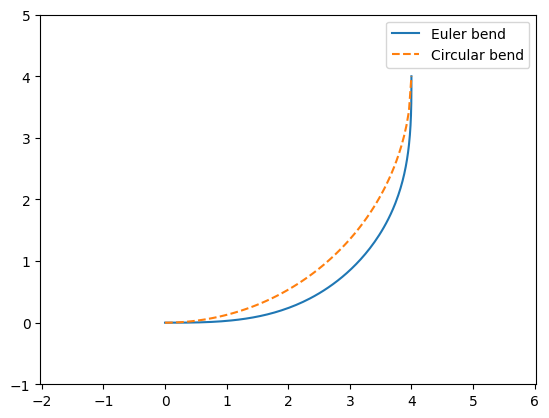

In [6]:
# obtain the coordinates of the whole Euler bend by concatenating three pieces together
x_euler = np.concatenate((x1, x2, x3))
y_euler = np.concatenate((y1, y2, y3))

# the conventional circular bend is simply given by a circle
x_circle = np.linspace(0, R_eff, 100)
y_circle = -np.sqrt(R_eff**2 - (x_circle) ** 2) + R_eff

# plotting the shapes of the Euler bend and the circular bend
plt.plot(x_euler, y_euler, label="Euler bend")
plt.plot(x_circle, y_circle, "--", label="Circular bend")
plt.axis("equal")
plt.ylim(-1, R_eff + 1)
plt.legend()
plt.show()


## Loss of a Circular Bend

We first simulate a circular waveguide bend as a baseline reference. Then in the next section, we will simulate an Euler bend and compare their losses quantitatively. Both simulations share the same parameters and simulation setup. The only difference is the bend structure.

In [7]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 100)  # simulation wavelength range
freqs = td.C_0 / ldas  # simulation wavelength range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # frequency width of the souce


In [8]:
t = 0.21  # thickness of the waveguide
w = 0.4  # width of the waveguide
inf_eff = 100  # effective infinity of the simulation
buffer = 1  # buffer distance


The silicon waveguide on the oxide substrate has an oxide top cladding. Therefore, we will define two materials for the simulations. Both are modeled as non-dispersive in this case.

In [9]:
n_si = 3.476  # silicon refractive index
si = td.Medium(permittivity=n_si**2)

n_sio2 = 1.444  # silicon oxide refractive index
sio2 = td.Medium(permittivity=n_sio2**2)


In the previous section, we obtained the coordinates that describe the Euler bend and the circular bend. To construct the 3D waveguide bend structure, we define a helper function here. We make use of `gdstk` to convert the coordinates of a bend to a Tidy3D [PolySlab](../api/_autosummary/tidy3d.PolySlab.html).

In [10]:
# function that takes the x and y coordinates of a curve and returns a waveguide bend structure with a given width and thickness
def line_to_structure(x, y, w, t):
   
    cell = gdstk.Cell("bend") # define a gds cell
    
    # add points to include the input and output straght waveguides
    x = np.insert(x, 0, -inf_eff)
    x = np.append(x, R_eff)
    y = np.insert(y,0,0)
    y = np.append(y, inf_eff)

    cell.add(gdstk.FlexPath(x + 1j * y, w, layer=1, datatype=0)) # add path to cell
    
    # define structure from cell
    bend = td.Structure(
        geometry=td.PolySlab.from_gds(
            cell,
            gds_layer=1,
            axis=2,
            slab_bounds=(0, t),
        )[0], 
        medium=si
    )

    return bend


Use the `line_to_structure` function to create the circular bend structure.

In [11]:
circular_bend = line_to_structure(x_circle, y_circle, w, t)


Defined a [ModeSource](../api/_autosummary/tidy3d.ModeSource.html) for excitation, a [ModeMonitor](../api/_autosummary/tidy3d.ModeMonitor.html) for detecting transmission, and a [FieldMonitor](../api/_autosummary/tidy3d.FieldMonitor.html) to visualize the field propagation and leakage in the bend. The fundamental TE mode is excited in the input waveguide. All boundaries are set to [PML](../api/_autosummary/tidy3d.PML.html) for efficient absorption of the outgoing radiation. Using an [automatic nonuniform grid](https://www.flexcompute.com/tidy3d/examples/notebooks/AutoGrid/) is the most efficient and convenient. We set `min_steps_per_wvl=20` to achieve a very accurate result while still keeping the simulation cost at a minimum.

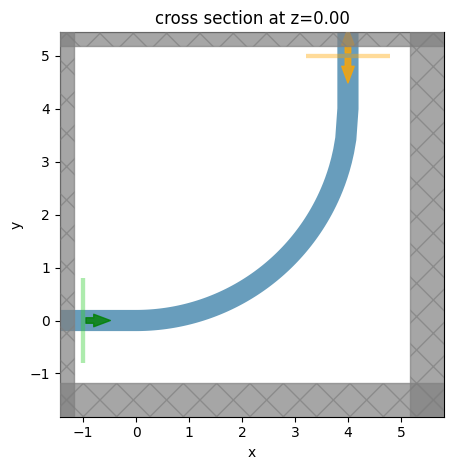

In [12]:
# add a mode source that launches the fundamental te mode
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_si)
mode_source = td.ModeSource(
    center=(-buffer, 0, t / 2),
    size=(0, 4 * w, 6 * t),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# add a mode monitor to measure transmission
mode_monitor = td.ModeMonitor(
    center=(R_eff, R_eff + buffer, t / 2),
    size=(4 * w, 0, 6 * t),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)


# add a field monitor to visualize field propagation and leakage in the bend
field_monitor = td.FieldMonitor(
    center=(R_eff / 2, R_eff / 2, t / 2),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    colocate=True,
    name="field",
)


run_time = 5e-13  # simulation run time

# define simulation
sim = td.Simulation(
    center=(R_eff / 2, R_eff / 2, t / 2),
    size=(R_eff + 2 * w + lda0, R_eff + 2 * w + lda0, 10 * t),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=[circular_bend],
    sources=[mode_source],
    monitors=[mode_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(
        boundary=td.PML()
    ),  # pml is applied in all boundaries
    medium=sio2,
)  # background medium is set to sio2 because of the substrate and upper cladding

# visualize the circular bend structure
sim.plot(z=0)
plt.show()


Submit the simulation job to the server.

In [13]:
job = web.Job(simulation=sim, task_name="circular_bend")
sim_data_circular = job.run(path="data/simulation_data_circular.hdf5")


21:09:08 PST Created task 'circular_bend' with task_id                          
             'fdve-db11ca8d-8ad1-4a24-a739-5fc5ff4825b4' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=527245;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db11ca8d-8ad1-4a24-a739-5fc5ff4825b4\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=934497;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db11ca8d-8ad1-4a24-a739-5fc5ff4825b4\taskId]8;;\]8;id=527245;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db11ca8d-8ad1-4a24-a739-5fc5ff4825b4\=]8;;\]8;id=643205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db11ca8d-8ad1-4a24-a739-5fc5ff4825b4\fdve]8;;\]8;id=527245;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db11ca8d-8ad1-4a24-a739-5fc5ff4825b4\-db11ca8d-8ad]8;;\
             ]8;id=527245;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db11ca8d-8ad1-4a24-a739-5fc5ff4825b4\1-4a24-a739-5fc5ff4825b4']8;;\.

Output()

21:09:10 PST status = queued

Output()

21:09:15 PST status = preprocess

21:09:17 PST Maximum FlexCredit cost: 0.042. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

21:09:36 PST early shutoff detected at 68%, exiting.

             status = postprocess

Output()

21:09:39 PST status = success

             View simulation result at                                          
             ]8;id=722045;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db11ca8d-8ad1-4a24-a739-5fc5ff4825b4\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=665888;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db11ca8d-8ad1-4a24-a739-5fc5ff4825b4\taskId]8;;\]8;id=722045;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db11ca8d-8ad1-4a24-a739-5fc5ff4825b4\=]8;;\]8;id=935107;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db11ca8d-8ad1-4a24-a739-5fc5ff4825b4\fdve]8;;\]8;id=722045;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db11ca8d-8ad1-4a24-a739-5fc5ff4825b4\-db11ca8d-8ad]8;;\
             ]8;id=722045;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db11ca8d-8ad1-4a24-a739-5fc5ff4825b4\1-4a24-a739-5fc5ff4825b4']8;;\.

Output()

21:09:40 PST loading simulation from data/simulation_data_circular.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

After the simulation is complete, we first plot the bending loss as a function of wavelength. The circular bend exhibits a bending loss ~0.015 dB, which is already pretty low. In many applications, circular waveguide bends can meet the requirement. 

21:09:41 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

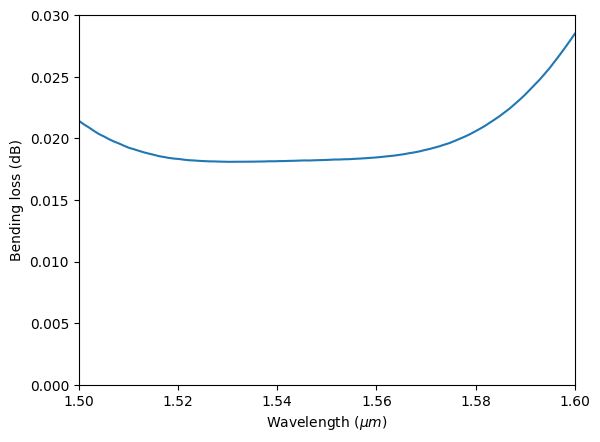

In [14]:
# extract the transmission data from the mode monitor
amp = sim_data_circular["mode"].amps.sel(mode_index=0, direction="+")
T_circular = np.abs(amp)**2 

# plot the bending loss as a function of wavelength
plt.plot(ldas, -10 * np.log10(T_circular))
plt.xlim(1.5, 1.6)
plt.ylim(0, 0.03)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Bending loss (dB)")
plt.show()


To inspect where the loss occurs in the bend, we plot the field intensity in log scale.

The energy leakage manifests as field intensity outside of the waveguide. Here we can see that leakage occurs around the transition region where the straight waveguide meets the circular waveguide. This is due to the abrupt change of curvature.

/home/momchil/miniconda3/envs/tidy3d-test/lib/python3.10/site-packages/xarray/core/computation.py:808: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


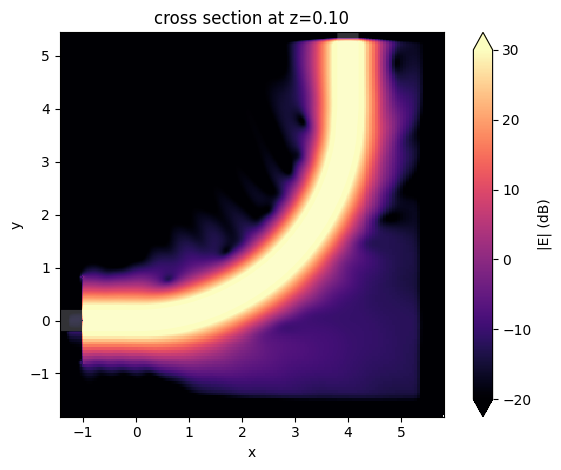

In [15]:
sim_data_circular.plot_field(
    field_monitor_name="field",
    field_name="E",
    val="abs",
    scale="dB",
    vmin=-20,
    vmax=30,
)
plt.show()


## Loss of an Euler Bend

Next, we perform a similar simulation for the Euler waveguide bend and compare the results to the circular bend. The Euler waveguide bend structure is made by using the `line_to_structure` function we defined earlier. Since the simulation setup is the same as the previous one with the only difference being the structures, we can simply copy the previous simulation and update the structures.

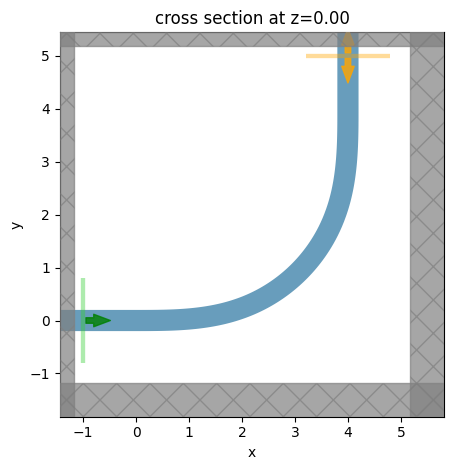

In [16]:
# create the euler waveguide bend structure
euler_bend = line_to_structure(x_euler, y_euler, w, t)

# construct the simulation by copying the previous simulation and updating the structure
sim = sim.copy(update={"structures": [euler_bend]})

# visualize the euler bend structure
sim.plot(z=0)
plt.show()


Submit the simulation to the server.

In [17]:
job = web.Job(simulation=sim, task_name="circular_bend")
sim_data_euler = job.run(path="data/simulation_data_euler.hdf5")


21:09:42 PST Created task 'circular_bend' with task_id                          
             'fdve-329eae11-7c97-46cc-8f8f-a8e51e09fdd2' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=964111;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329eae11-7c97-46cc-8f8f-a8e51e09fdd2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=858590;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329eae11-7c97-46cc-8f8f-a8e51e09fdd2\taskId]8;;\]8;id=964111;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329eae11-7c97-46cc-8f8f-a8e51e09fdd2\=]8;;\]8;id=815517;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329eae11-7c97-46cc-8f8f-a8e51e09fdd2\fdve]8;;\]8;id=964111;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329eae11-7c97-46cc-8f8f-a8e51e09fdd2\-329eae11-7c9]8;;\
             ]8;id=964111;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329eae11-7c97-46cc-8f8f-a8e51e09fdd2\7-46cc-8f8f-a8e51e09fdd2']8;;\.

Output()

21:09:43 PST status = queued

Output()

21:09:49 PST status = preprocess

21:09:50 PST Maximum FlexCredit cost: 0.042. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

21:10:10 PST early shutoff detected at 68%, exiting.

             status = postprocess

Output()

21:10:13 PST status = success

             View simulation result at                                          
             ]8;id=328074;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329eae11-7c97-46cc-8f8f-a8e51e09fdd2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=281475;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329eae11-7c97-46cc-8f8f-a8e51e09fdd2\taskId]8;;\]8;id=328074;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329eae11-7c97-46cc-8f8f-a8e51e09fdd2\=]8;;\]8;id=370845;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329eae11-7c97-46cc-8f8f-a8e51e09fdd2\fdve]8;;\]8;id=328074;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329eae11-7c97-46cc-8f8f-a8e51e09fdd2\-329eae11-7c9]8;;\
             ]8;id=328074;https://tidy3d.simulation.cloud/workbench?taskId=fdve-329eae11-7c97-46cc-8f8f-a8e51e09fdd2\7-46cc-8f8f-a8e51e09fdd2']8;;\.

Output()

21:10:14 PST loading simulation from data/simulation_data_euler.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

After the simulation is complete, we plot the bending loss of the Euler bend against that of the circular bend. Here we see that the Euler bend has a lower loss ~0.005 dB. In terms of absolute loss, both bends are very good. However, when a large number of waveguide bends are used in an integrated photonic circuit, the advantage of the Euler bend can be quite significant.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

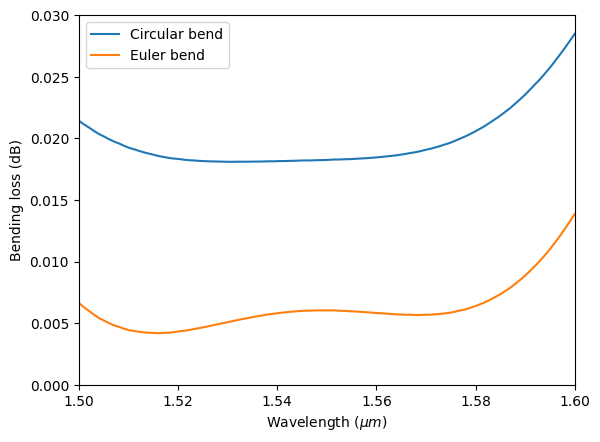

In [18]:
# extract the transmission data from the mode monitor
amp = sim_data_euler["mode"].amps.sel(mode_index=0, direction="+")
T_euler = np.abs(amp)**2 

# plotting the losses
plt.plot(ldas, -10 * np.log10(T_circular), label="Circular bend")
plt.plot(ldas, -10 * np.log10(T_euler), label="Euler bend")
plt.xlim(1.5, 1.6)
plt.ylim(0, 0.03)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Bending loss (dB)")
plt.legend()
plt.show()


Similarly, we plot the field intensity in log scale. From the plot, we can see that the leakage around the transition regions is indeed reduced. This is due to the fact that the curvature of the Euler curve varies smoothly.

/home/momchil/miniconda3/envs/tidy3d-test/lib/python3.10/site-packages/xarray/core/computation.py:808: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


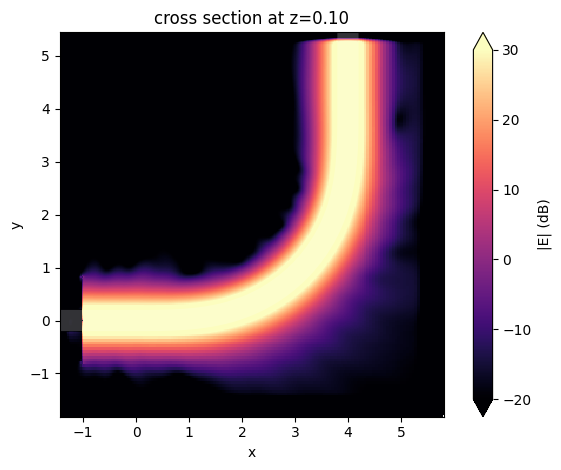

In [19]:
sim_data_euler.plot_field(
    field_monitor_name="field",
    field_name="E",
    val="abs",
    scale="dB",
    vmin=-20,
    vmax=30,
)
plt.show()
